<a href="https://colab.research.google.com/github/sreeshma15/ForecastingWaterConsumption/blob/main/ForecastingWaterConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print(" ML ENVIRONMENT SETUP COMPLETED")

 ML ENVIRONMENT SETUP COMPLETED


In [ ]:
print("\n=== PHASE 1: DATA EXPLORATION & UNDERSTANDING ===")
print("=" * 60)

# Load the organized dataset
df = pd.read_csv('/content/drive/MyDrive/organized_water_consumption_dataset.csv')

print("1.1 DATASET STRUCTURE EXAMINATION")
print("-" * 40)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData Types:")
print(df.dtypes)

print("\n1.2 COMPREHENSIVE DATA PROFILING")
print("-" * 40)

print("Missing Values Analysis:")
print(df.isnull().sum())

print(f"\nBasic Statistics:")
print(df.describe())

print(f"\nCategorical Variables Summary:")
categorical_cols = ['Country', 'Season', 'Water_Scarcity_Level']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

print("\n1.3 TEMPORAL AND GEOGRAPHICAL ANALYSIS")
print("-" * 40)

print(f"Year Range: {df['Year'].min()} to {df['Year'].max()}")
print(f"Number of Countries: {df['Country'].nunique()}")
print(f"Countries: {df['Country'].unique()}")

# Check data distribution by country and year
country_years = df.groupby('Country')['Year'].agg(['min', 'max', 'count'])
print(f"\nCountry-wise Data Distribution:")
print(country_years)


=== PHASE 1: DATA EXPLORATION & UNDERSTANDING ===
1.1 DATASET STRUCTURE EXAMINATION
----------------------------------------
Dataset Shape: (250, 13)
Columns: ['Country', 'Year', 'Season', 'Water_Scarcity_Level', 'Population_Millions', 'GDP_Per_Capita_K', 'Agricultural_Intensity', 'Industrial_Output_Index', 'Temperature_Anomaly', 'Precipitation_Index', 'Water_Efficiency_Score', 'Urbanization_Rate', 'Total_Water_Consumption']

First 5 rows:
     Country  Year  Season Water_Scarcity_Level  Population_Millions  \
0  Australia  2000  Summer                  Low                82.35   
1  Australia  2001  Summer                  Low                94.16   
2  Australia  2002    Fall             Moderate                85.55   
3  Australia  2003  Summer                  Low                93.95   
4  Australia  2004    Fall             Moderate                89.95   

   GDP_Per_Capita_K  Agricultural_Intensity  Industrial_Output_Index  \
0             40.19                   55.91       


1.4 DATA VISUALIZATIONS
----------------------------------------


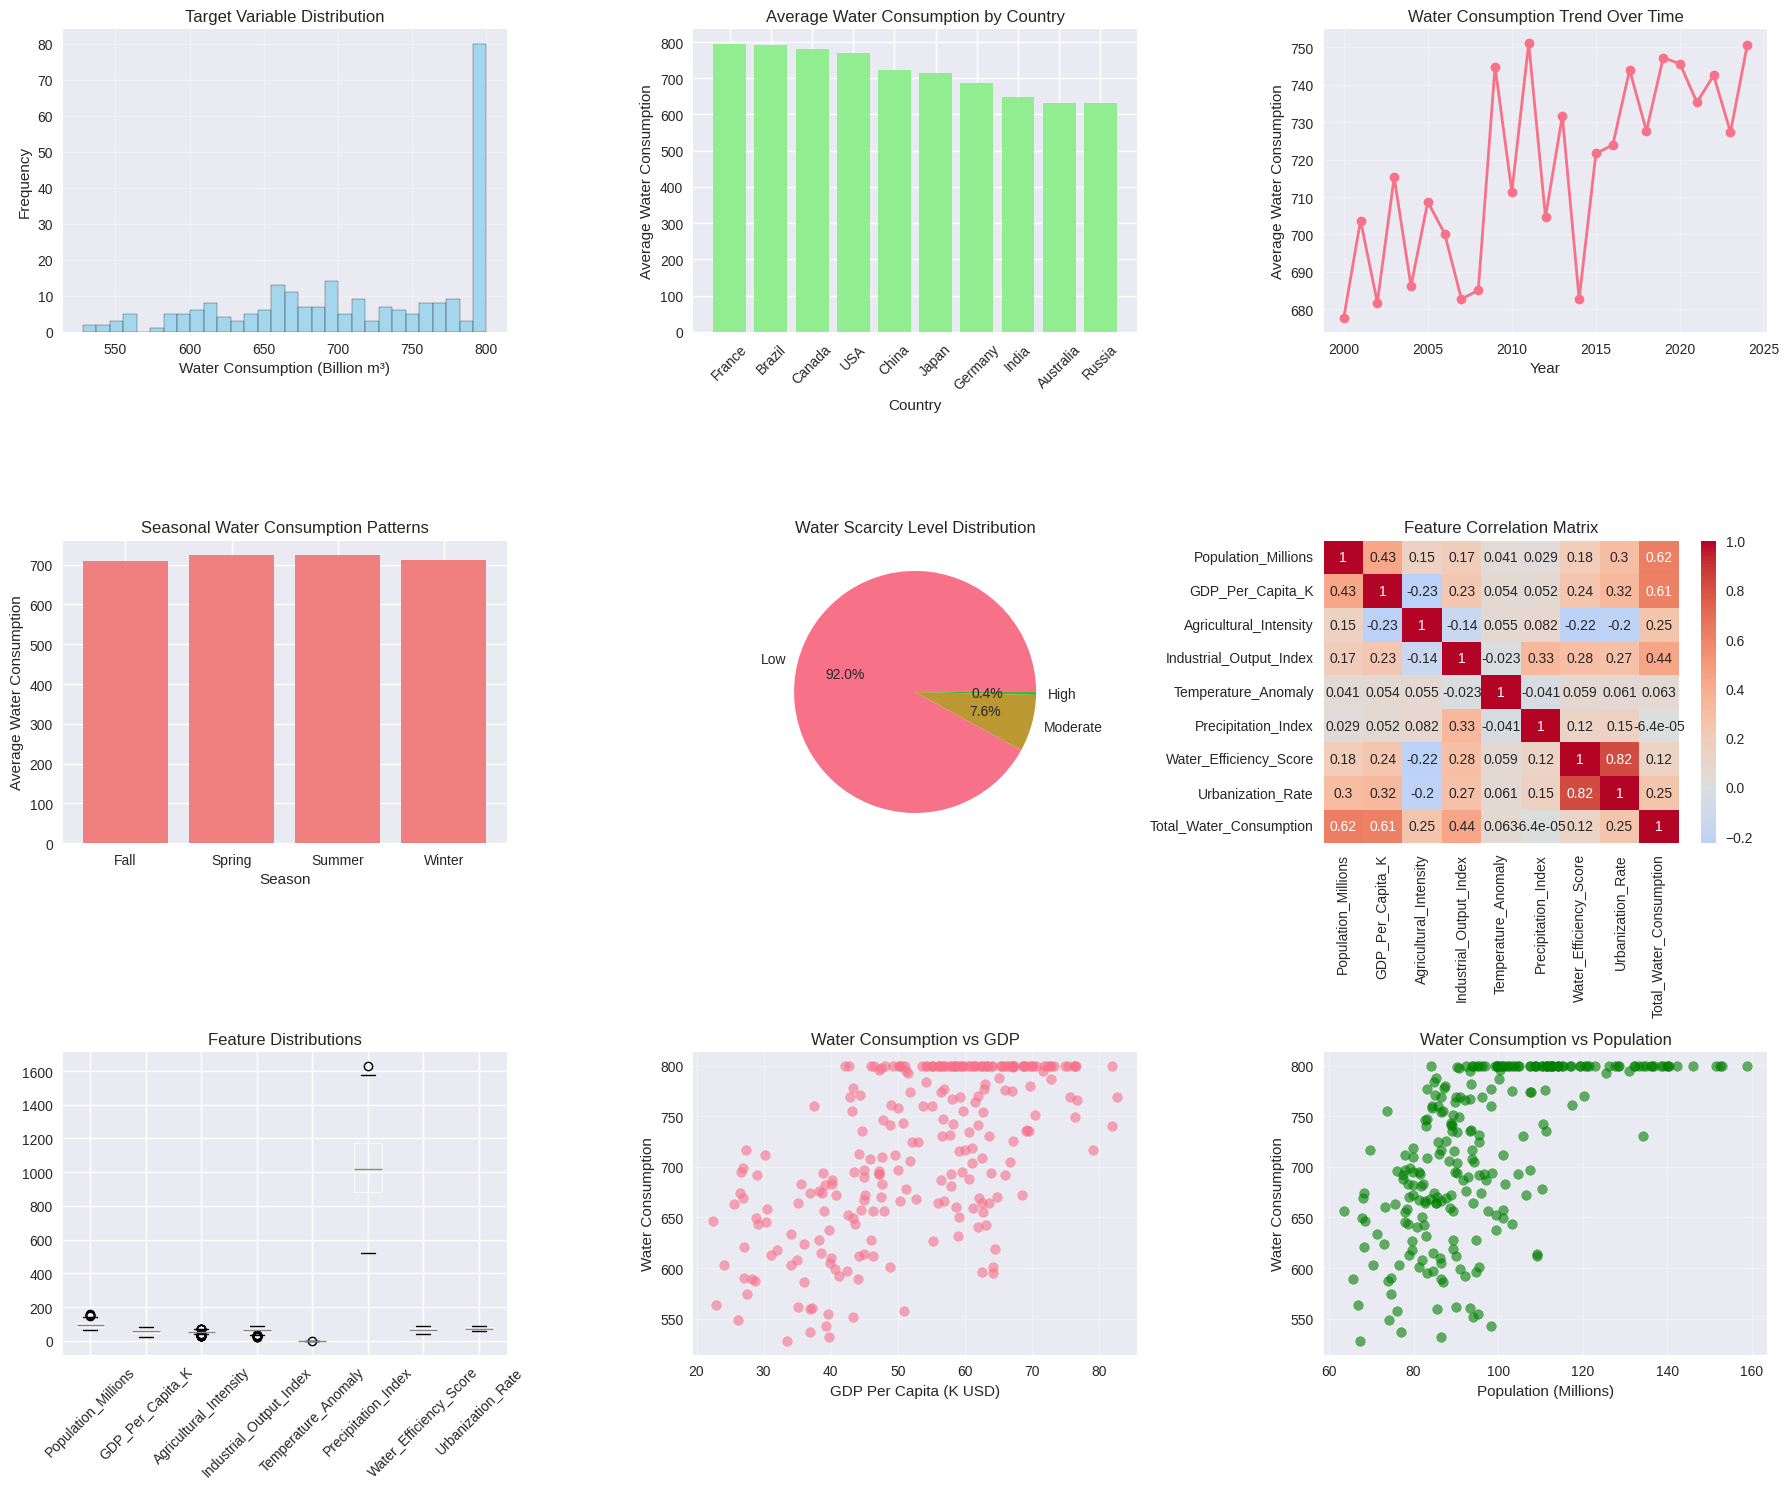


1.5 DATA QUALITY ASSESSMENT
----------------------------------------
Data Quality Check:
• Duplicate rows: 0
• Missing values: 0
• Infinite values: 0
• Zero values in critical features: 0
• Negative water consumption: 0
• Potential outliers in target: 0 (0.0%)

 PHASE 1 COMPLETED: Data understanding achieved


In [7]:
print("\n1.4 DATA VISUALIZATIONS")
print("-" * 40)

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1. Target variable distribution
axes[0, 0].hist(df['Total_Water_Consumption'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Water Consumption (Billion m³)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Target Variable Distribution')
axes[0, 0].grid(True, alpha=0.3)

# 2. Water consumption by country
country_avg = df.groupby('Country')['Total_Water_Consumption'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(country_avg)), country_avg.values, color='lightgreen')
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Average Water Consumption')
axes[0, 1].set_title('Average Water Consumption by Country')
axes[0, 1].set_xticks(range(len(country_avg)))
axes[0, 1].set_xticklabels(country_avg.index, rotation=45)

# 3. Temporal trend of water consumption
yearly_avg = df.groupby('Year')['Total_Water_Consumption'].mean()
axes[0, 2].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2)
axes[0, 2].set_xlabel('Year')
axes[0, 2].set_ylabel('Average Water Consumption')
axes[0, 2].set_title('Water Consumption Trend Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Seasonal patterns
seasonal_avg = df.groupby('Season')['Total_Water_Consumption'].mean()
axes[1, 0].bar(seasonal_avg.index, seasonal_avg.values, color='lightcoral')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Average Water Consumption')
axes[1, 0].set_title('Seasonal Water Consumption Patterns')

# 5. Water scarcity distribution
scarcity_counts = df['Water_Scarcity_Level'].value_counts()
axes[1, 1].pie(scarcity_counts.values, labels=scarcity_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Water Scarcity Level Distribution')

# 6. Feature correlations
numerical_features = ['Population_Millions', 'GDP_Per_Capita_K', 'Agricultural_Intensity',
                     'Industrial_Output_Index', 'Temperature_Anomaly', 'Precipitation_Index',
                     'Water_Efficiency_Score', 'Urbanization_Rate', 'Total_Water_Consumption']
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Matrix')

# 7. Feature distributions
df[numerical_features[:-1]].boxplot(ax=axes[2, 0])
axes[2, 0].set_title('Feature Distributions')
axes[2, 0].tick_params(axis='x', rotation=45)

# 8. Water consumption vs GDP
axes[2, 1].scatter(df['GDP_Per_Capita_K'], df['Total_Water_Consumption'], alpha=0.6)
axes[2, 1].set_xlabel('GDP Per Capita (K USD)')
axes[2, 1].set_ylabel('Water Consumption')
axes[2, 1].set_title('Water Consumption vs GDP')
axes[2, 1].grid(True, alpha=0.3)

# 9. Water consumption vs Population
axes[2, 2].scatter(df['Population_Millions'], df['Total_Water_Consumption'], alpha=0.6, color='green')
axes[2, 2].set_xlabel('Population (Millions)')
axes[2, 2].set_ylabel('Water Consumption')
axes[2, 2].set_title('Water Consumption vs Population')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n1.5 DATA QUALITY ASSESSMENT")
print("-" * 40)

# Check for potential data quality issues
print("Data Quality Check:")
print(f"• Duplicate rows: {df.duplicated().sum()}")
print(f"• Missing values: {df.isnull().sum().sum()}")
print(f"• Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")
print(f"• Zero values in critical features: {(df['Population_Millions'] == 0).sum()}")
print(f"• Negative water consumption: {(df['Total_Water_Consumption'] < 0).sum()}")

# Check for outliers using IQR method
Q1 = df['Total_Water_Consumption'].quantile(0.25)
Q3 = df['Total_Water_Consumption'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df['Total_Water_Consumption'] < (Q1 - 1.5 * IQR)) |
           (df['Total_Water_Consumption'] > (Q3 + 1.5 * IQR))).sum()
print(f"• Potential outliers in target: {outliers} ({outliers/len(df)*100:.1f}%)")

print("\n PHASE 1 COMPLETED: Data understanding achieved")

In [9]:
print("\n=== PHASE 2: DATA PREPROCESSING PIPELINE ===")
print("=" * 60)

# Create a copy for preprocessing
df_processed = df.copy()

print("2.1 HANDLING MISSING VALUES")
print("-" * 40)

# Check for missing values
missing_summary = df_processed.isnull().sum()
print("Missing values per column:")
for col, missing_count in missing_summary.items():
    if missing_count > 0:
        print(f"  {col}: {missing_count} missing values")

# Since our synthetic dataset has no missing values, we proceed
print("No missing values detected. Proceeding with preprocessing.")

print("\n2.2 FEATURE AND TARGET SEPARATION")
print("-" * 40)

# Separate features and target
X = df_processed.drop('Total_Water_Consumption', axis=1)
y = df_processed['Total_Water_Consumption']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

print("\n2.3 DATA SPLITTING")
print("-" * 40)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Country']
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Train/Test split: {X_train.shape[0]/len(X)*100:.1f}% / {X_test.shape[0]/len(X)*100:.1f}%")

# Check distribution in splits
print(f"\nCountry distribution in training set:")
print(X_train['Country'].value_counts())
print(f"\nCountry distribution in testing set:")
print(X_test['Country'].value_counts())

print("\n2.4 PREPROCESSING PIPELINE DESIGN")
print("-" * 40)

# Define feature types
numerical_features = ['Year', 'Population_Millions', 'GDP_Per_Capita_K',
                     'Agricultural_Intensity', 'Industrial_Output_Index',
                     'Temperature_Anomaly', 'Precipitation_Index',
                     'Water_Efficiency_Score', 'Urbanization_Rate']

categorical_features = ['Country', 'Season', 'Water_Scarcity_Level']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

print("\nPreprocessing Pipeline Rationale:")
print("1. StandardScaler for numerical features: Ensures all features have same scale")
print("2. OneHotEncoder for categorical features: Converts categories to binary columns")
print("3. handle_unknown='ignore': Handles unseen categories in test set")
print("4. No missing value handling needed: Dataset is complete")

print("\n PHASE 2 COMPLETED: Preprocessing pipeline ready")


=== PHASE 2: DATA PREPROCESSING PIPELINE ===
2.1 HANDLING MISSING VALUES
----------------------------------------
Missing values per column:
No missing values detected. Proceeding with preprocessing.

2.2 FEATURE AND TARGET SEPARATION
----------------------------------------
Features shape: (250, 12)
Target shape: (250,)

2.3 DATA SPLITTING
----------------------------------------
Training set: 200 samples
Testing set: 50 samples
Train/Test split: 80.0% / 20.0%

Country distribution in training set:
Country
Russia       20
China        20
India        20
Canada       20
Brazil       20
USA          20
France       20
Germany      20
Japan        20
Australia    20
Name: count, dtype: int64

Country distribution in testing set:
Country
India        5
Brazil       5
China        5
Canada       5
USA          5
Japan        5
Russia       5
France       5
Germany      5
Australia    5
Name: count, dtype: int64

2.4 PREPROCESSING PIPELINE DESIGN
----------------------------------------
Nu


=== PHASE 3: FEATURE ENGINEERING & SELECTION ===
3.1 FEATURE CORRELATION ANALYSIS
----------------------------------------
Feature correlations with water consumption:
  Population_Millions      :   0.616 (STRONG positive)
  GDP_Per_Capita_K         :   0.614 (STRONG positive)
  Industrial_Output_Index  :   0.439 (MODERATE positive)
  Urbanization_Rate        :   0.248 (WEAK positive)
  Agricultural_Intensity   :   0.248 (WEAK positive)
  Year                     :   0.224 (WEAK positive)
  Water_Efficiency_Score   :   0.117 (WEAK positive)
  Temperature_Anomaly      :   0.063 (WEAK positive)
  Precipitation_Index      :  -0.000 (WEAK negative)


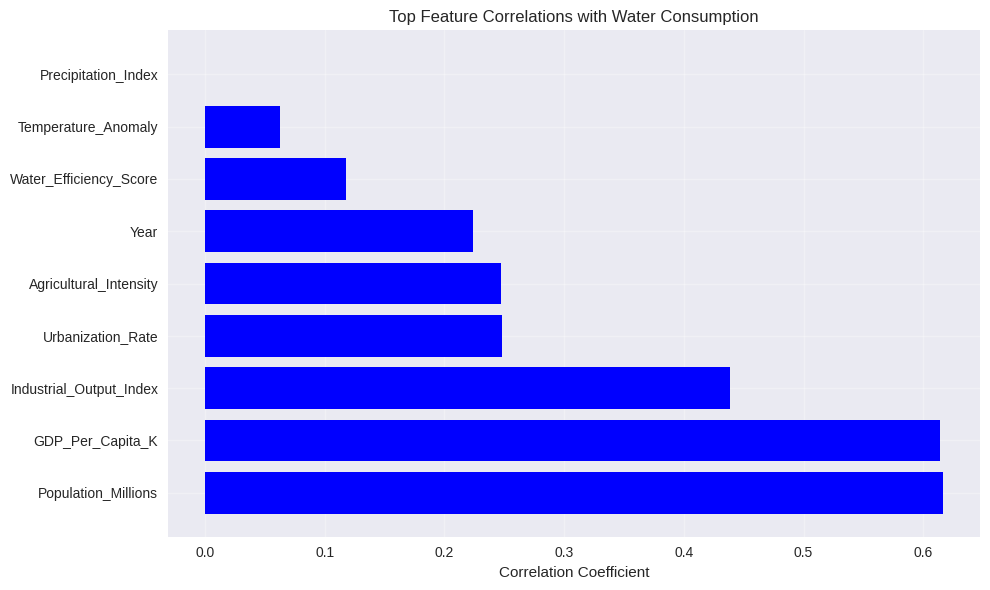


3.2 FEATURE ENGINEERING
----------------------------------------
Added engineered features:
  • ['Population_GDP_Interaction', 'Agri_Water_Efficiency', 'Industry_Population_Ratio', 'Years_Since_2000', 'Is_Recent', 'Water_Stress_Indicator']

3.3 UPDATED FEATURE SET
----------------------------------------
Final feature set for modeling:
Numerical features (15): ['Year', 'Population_Millions', 'GDP_Per_Capita_K', 'Agricultural_Intensity', 'Industrial_Output_Index', 'Temperature_Anomaly', 'Precipitation_Index', 'Water_Efficiency_Score', 'Urbanization_Rate', 'Population_GDP_Interaction', 'Agri_Water_Efficiency', 'Industry_Population_Ratio', 'Years_Since_2000', 'Is_Recent', 'Water_Stress_Indicator']
Categorical features (3): ['Country', 'Season', 'Water_Scarcity_Level']

 PHASE 3 COMPLETED: Feature engineering and selection done


In [10]:
print("\n=== PHASE 3: FEATURE ENGINEERING & SELECTION ===")
print("=" * 60)

print("3.1 FEATURE CORRELATION ANALYSIS")
print("-" * 40)

# Calculate correlations with target
correlation_with_target = df[numerical_features + ['Total_Water_Consumption']].corr()['Total_Water_Consumption'].sort_values(ascending=False)

print("Feature correlations with water consumption:")
for feature, corr in correlation_with_target.items():
    if feature != 'Total_Water_Consumption':
        strength = "STRONG" if abs(corr) > 0.5 else "MODERATE" if abs(corr) > 0.3 else "WEAK"
        direction = "positive" if corr > 0 else "negative"
        print(f"  {feature:25}: {corr:7.3f} ({strength} {direction})")

# Visualize top correlations
plt.figure(figsize=(10, 6))
top_corr_features = correlation_with_target[1:11]  # Exclude target itself
colors = ['red' if x < 0 else 'blue' for x in top_corr_features.values]

plt.barh(range(len(top_corr_features)), top_corr_features.values, color=colors)
plt.yticks(range(len(top_corr_features)), top_corr_features.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top Feature Correlations with Water Consumption')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n3.2 FEATURE ENGINEERING")
print("-" * 40)

# Create additional engineered features
X_engineered = X.copy()

# Add interaction features
X_engineered['Population_GDP_Interaction'] = X_engineered['Population_Millions'] * X_engineered['GDP_Per_Capita_K']
X_engineered['Agri_Water_Efficiency'] = X_engineered['Agricultural_Intensity'] / (X_engineered['Water_Efficiency_Score'] + 1)
X_engineered['Industry_Population_Ratio'] = X_engineered['Industrial_Output_Index'] / (X_engineered['Population_Millions'] + 1)

# Add temporal features
X_engineered['Years_Since_2000'] = X_engineered['Year'] - 2000
X_engineered['Is_Recent'] = (X_engineered['Year'] >= 2015).astype(int)

# Add combined water stress indicator
X_engineered['Water_Stress_Indicator'] = (X_engineered['Precipitation_Index'] / 1000) * X_engineered['Water_Efficiency_Score']

print("Added engineered features:")
new_features = ['Population_GDP_Interaction', 'Agri_Water_Efficiency', 'Industry_Population_Ratio',
               'Years_Since_2000', 'Is_Recent', 'Water_Stress_Indicator']
print(f"  • {new_features}")

# Update numerical features list
numerical_features_extended = numerical_features + new_features

print("\n3.3 UPDATED FEATURE SET")
print("-" * 40)

print("Final feature set for modeling:")
print(f"Numerical features ({len(numerical_features_extended)}): {numerical_features_extended}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Update preprocessor with extended features
preprocessor_extended = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_extended),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

print("\n PHASE 3 COMPLETED: Feature engineering and selection done")

In [ ]:
print("\n=== PHASE 4: MODEL DEVELOPMENT & TRAINING ===")
print("=" * 60)

print("4.1 DATA PREPARATION FOR MODELING")
print("-" * 40)

# Apply preprocessing to training data
X_train_processed = preprocessor_extended.fit_transform(X_engineered.loc[X_train.index])
X_test_processed = preprocessor_extended.transform(X_engineered.loc[X_test.index])

# Get feature names after preprocessing
feature_names = (numerical_features_extended +
                list(preprocessor_extended.named_transformers_['cat'].get_feature_names_out(categorical_features)))

print(f"Processed training features shape: {X_train_processed.shape}")
print(f"Processed testing features shape: {X_test_processed.shape}")
print(f"Total features after preprocessing: {len(feature_names)}")


=== PHASE 4: MODEL DEVELOPMENT & TRAINING ===
4.1 DATA PREPARATION FOR MODELING
----------------------------------------
Processed training features shape: (200, 32)
Processed testing features shape: (50, 32)
Total features after preprocessing: 32



4.2 K-NEAREST NEIGHBORS REGRESSOR
----------------------------------------
KNN Algorithm Characteristics:
• Non-parametric, instance-based learning
• Finds similar patterns in feature space
• Sensitive to feature scaling and k value
Performing GridSearchCV for KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best KNN parameters: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 11, 'regressor__weights': 'distance'}
Best KNN cross-validation R²: 0.6461

KNN TEST PERFORMANCE:
• Root Mean Squared Error (RMSE): 42.67
• Mean Absolute Error (MAE): 33.31
• R-squared (R²): 0.7261
• Explained variance: 72.6%


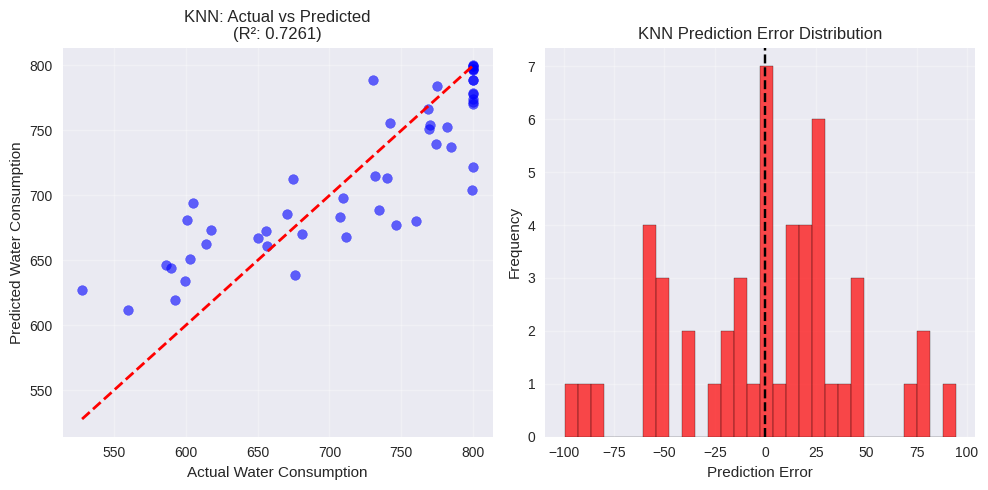

In [ ]:
print("\n4.2 K-NEAREST NEIGHBORS REGRESSOR")
print("-" * 40)

print("KNN Algorithm Characteristics:")
print("• Non-parametric, instance-based learning")
print("• Finds similar patterns in feature space")
print("• Sensitive to feature scaling and k value")

# Create KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor_extended),
    ('regressor', KNeighborsRegressor())
])

# Hyperparameter tuning
knn_param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 15],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan']
}

print("Performing GridSearchCV for KNN...")

# Apply feature engineering to training and testing sets before fitting GridSearchCV
X_train_engineered = X_engineered.loc[X_train.index]
X_test_engineered = X_engineered.loc[X_test.index]

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
knn_grid.fit(X_train_engineered, y_train)

print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"Best KNN cross-validation R²: {knn_grid.best_score_:.4f}")

# Best KNN model
best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_test_engineered)

# Calculate metrics
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_mae = mean_absolute_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

print(f"\nKNN TEST PERFORMANCE:")
print(f"• Root Mean Squared Error (RMSE): {knn_rmse:.2f}")
print(f"• Mean Absolute Error (MAE): {knn_mae:.2f}")
print(f"• R-squared (R²): {knn_r2:.4f}")
print(f"• Explained variance: {knn_r2*100:.1f}%")

# Visualize KNN predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_knn, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'KNN: Actual vs Predicted\n(R²: {knn_r2:.4f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors_knn = y_test - y_pred_knn
plt.hist(errors_knn, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('KNN Prediction Error Distribution')
plt.axvline(x=0, color='k', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


4.3 RIDGE REGRESSION
----------------------------------------
Ridge Regression Characteristics:
• Linear model with L2 regularization
• Handles multicollinearity well
• All features contribute to predictions
Performing GridSearchCV for Ridge...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Ridge alpha: {'regressor__alpha': 0.1}
Best Ridge cross-validation R²: 0.7624

RIDGE REGRESSION TEST PERFORMANCE:
• Root Mean Squared Error (RMSE): 36.49
• Mean Absolute Error (MAE): 29.05
• R-squared (R²): 0.7997
• Explained variance: 80.0%
• Number of features used: 32
• Average coefficient magnitude: 21.3099


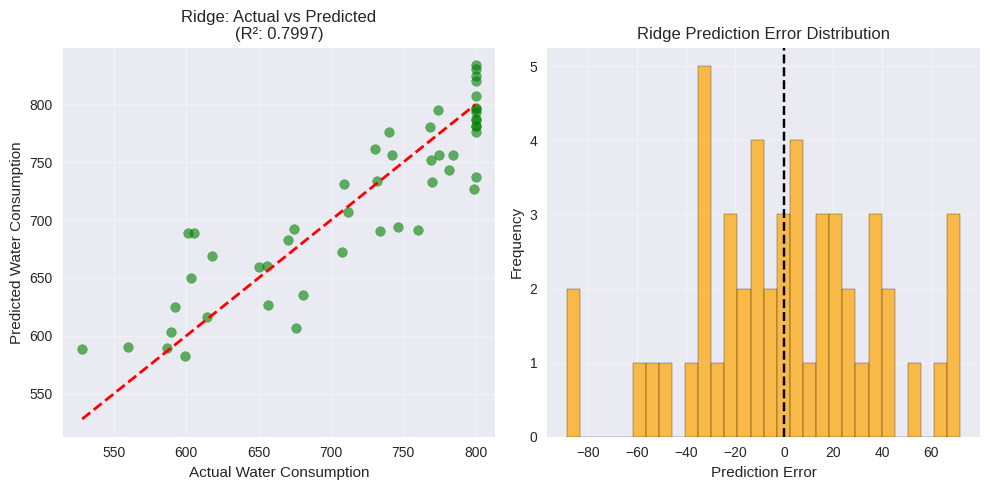

In [ ]:
print("\n4.3 RIDGE REGRESSION")
print("-" * 40)

print("Ridge Regression Characteristics:")
print("• Linear model with L2 regularization")
print("• Handles multicollinearity well")
print("• All features contribute to predictions")

# Create Ridge pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor_extended),
    ('regressor', Ridge(random_state=42))
])

# Hyperparameter tuning
ridge_param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

print("Performing GridSearchCV for Ridge...")

# Apply feature engineering to training and testing sets before fitting GridSearchCV
X_train_engineered = X_engineered.loc[X_train.index]
X_test_engineered = X_engineered.loc[X_test.index]

ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
ridge_grid.fit(X_train_engineered, y_train)

print(f"Best Ridge alpha: {ridge_grid.best_params_}")
print(f"Best Ridge cross-validation R²: {ridge_grid.best_score_:.4f}")

# Best Ridge model
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_engineered)

# Calculate metrics
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"\nRIDGE REGRESSION TEST PERFORMANCE:")
print(f"• Root Mean Squared Error (RMSE): {ridge_rmse:.2f}")
print(f"• Mean Absolute Error (MAE): {ridge_mae:.2f}")
print(f"• R-squared (R²): {ridge_r2:.4f}")
print(f"• Explained variance: {ridge_r2*100:.1f}%")

# Get coefficients for interpretation
ridge_coefficients = best_ridge.named_steps['regressor'].coef_
print(f"• Number of features used: {len(ridge_coefficients)}")
print(f"• Average coefficient magnitude: {np.mean(np.abs(ridge_coefficients)):.4f}")

# Visualize Ridge predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'Ridge: Actual vs Predicted\n(R²: {ridge_r2:.4f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors_ridge = y_test - y_pred_ridge
plt.hist(errors_ridge, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Ridge Prediction Error Distribution')
plt.axvline(x=0, color='k', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


4.4 LASSO REGRESSION
----------------------------------------
LASSO Regression Characteristics:
• Linear model with L1 regularization
• Automatic feature selection
• Can zero out unimportant features
Performing GridSearchCV for LASSO...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best LASSO alpha: {'regressor__alpha': 0.1}
Best LASSO cross-validation R²: 0.7678

LASSO REGRESSION TEST PERFORMANCE:
• Root Mean Squared Error (RMSE): 35.31
• Mean Absolute Error (MAE): 28.55
• R-squared (R²): 0.8124
• Explained variance: 81.2%

LASSO FEATURE SELECTION ANALYSIS:
• Total features available: 32
• Features selected (non-zero coefficients): 26
• Features eliminated (zero coefficients): 6
• Feature reduction rate: 18.8%


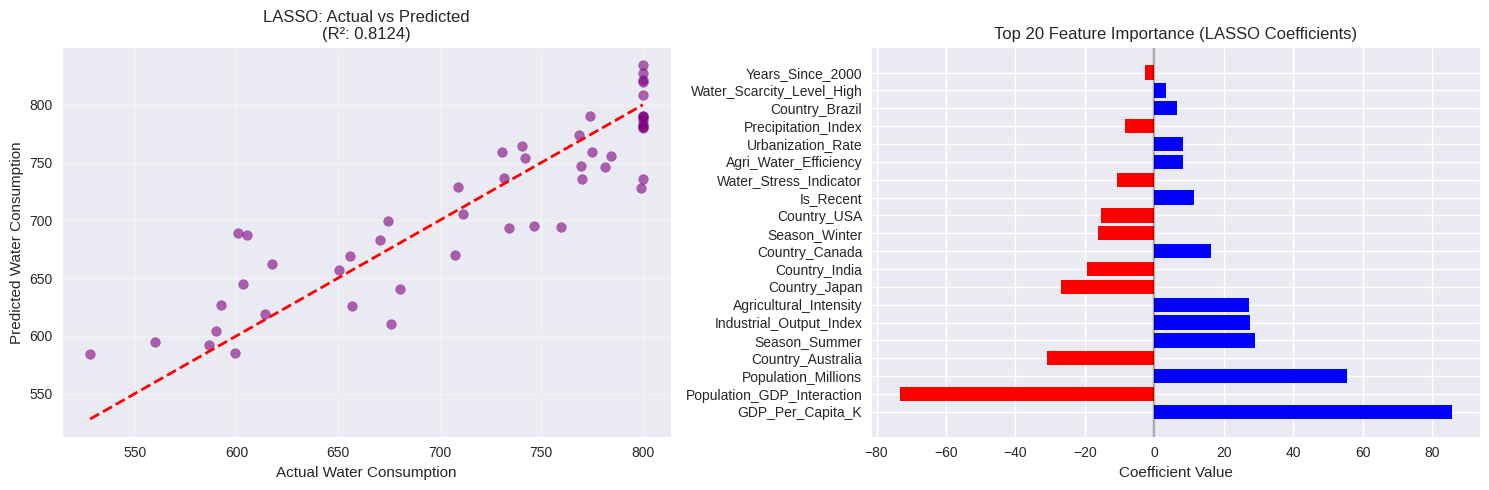


Top 10 Most Important Features (LASSO):
                   Feature  Coefficient
          GDP_Per_Capita_K    85.883277
Population_GDP_Interaction   -73.343456
       Population_Millions    55.617283
         Country_Australia   -30.873128
             Season_Summer    29.076580
   Industrial_Output_Index    27.477762
    Agricultural_Intensity    27.243693
             Country_Japan   -26.942859
             Country_India   -19.374601
            Country_Canada    16.265619


In [ ]:
print("\n4.4 LASSO REGRESSION")
print("-" * 40)

print("LASSO Regression Characteristics:")
print("• Linear model with L1 regularization")
print("• Automatic feature selection")
print("• Can zero out unimportant features")

# Create LASSO pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor_extended),
    ('regressor', Lasso(random_state=42, max_iter=10000))
])

# Hyperparameter tuning
lasso_param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

print("Performing GridSearchCV for LASSO...")

# Apply feature engineering to training and testing sets before fitting GridSearchCV
X_train_engineered = X_engineered.loc[X_train.index]
X_test_engineered = X_engineered.loc[X_test.index]

lasso_grid = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
lasso_grid.fit(X_train_engineered, y_train)

print(f"Best LASSO alpha: {lasso_grid.best_params_}")
print(f"Best LASSO cross-validation R²: {lasso_grid.best_score_:.4f}")

# Best LASSO model
best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_engineered)

# Calculate metrics
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print(f"\nLASSO REGRESSION TEST PERFORMANCE:")
print(f"• Root Mean Squared Error (RMSE): {lasso_rmse:.2f}")
print(f"• Mean Absolute Error (MAE): {lasso_mae:.2f}")
print(f"• R-squared (R²): {lasso_r2:.4f}")
print(f"• Explained variance: {lasso_r2*100:.1f}%")

# Feature selection analysis
lasso_coefficients = best_lasso.named_steps['regressor'].coef_
selected_features = np.sum(lasso_coefficients != 0)
total_features = len(lasso_coefficients)

print(f"\nLASSO FEATURE SELECTION ANALYSIS:")
print(f"• Total features available: {total_features}")
print(f"• Features selected (non-zero coefficients): {selected_features}")
print(f"• Features eliminated (zero coefficients): {total_features - selected_features}")
print(f"• Feature reduction rate: {(total_features - selected_features)/total_features*100:.1f}%")

# Visualize LASSO predictions and feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Predictions vs actual
axes[0].scatter(y_test, y_pred_lasso, alpha=0.6, color='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Water Consumption')
axes[0].set_ylabel('Predicted Water Consumption')
axes[0].set_title(f'LASSO: Actual vs Predicted\n(R²: {lasso_r2:.4f})')
axes[0].grid(True, alpha=0.3)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients,
    'Absolute_Coefficient': np.abs(lasso_coefficients)
}).sort_values('Absolute_Coefficient', ascending=False)

top_20_features = feature_importance.head(20)
colors = ['red' if x < 0 else 'blue' for x in top_20_features['Coefficient']]

axes[1].barh(range(len(top_20_features)), top_20_features['Coefficient'], color=colors)
axes[1].set_yticks(range(len(top_20_features)))
axes[1].set_yticklabels(top_20_features['Feature'])
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Top 20 Feature Importance (LASSO Coefficients)')
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (LASSO):")
print(top_20_features[['Feature', 'Coefficient']].head(10).to_string(index=False))

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Load data
df = pd.read_csv('/content/drive/MyDrive/organized_water_consumption_dataset.csv')

# Preprocessing
le_country = LabelEncoder()
le_scarcity = LabelEncoder()
df['Country_encoded'] = le_country.fit_transform(df['Country'])
df['Water_Scarcity_encoded'] = le_scarcity.fit_transform(df['Water_Scarcity_Level'])

features = ['Year', 'Population_Millions', 'Agricultural_Intensity',
           'Industrial_Output_Index', 'Urbanization_Rate', 'Precipitation_Index',
           'Water_Efficiency_Score', 'Country_encoded', 'Water_Scarcity_encoded']
target = 'Total_Water_Consumption'

X = df[features]
y = df[target]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LASSO
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=5000)
lasso_model.fit(X_train_scaled, y_train)
accuracy = r2_score(y_test, lasso_model.predict(X_test_scaled))

print("=== LASSO REGRESSION PREDICTION ===")
print("Enter values for prediction:")

# Get user input
country = input("Country (e.g., USA, China, India): ")
year = int(input("Year (2000-2024): "))
population = float(input("Population (Millions): "))
agricultural = float(input("Agricultural Intensity (%): "))
industrial = float(input("Industrial Output Index: "))
urbanization = float(input("Urbanization Rate (%): "))
precipitation = float(input("Precipitation Index: "))
water_efficiency = float(input("Water Efficiency Score: "))
scarcity = input("Water Scarcity (Low/Moderate/High): ")

# Encode and predict
country_encoded = le_country.transform([country])[0]
scarcity_encoded = le_scarcity.transform([scarcity])[0]

user_input = np.array([[year, population, agricultural, industrial, urbanization,
                       precipitation, water_efficiency, country_encoded, scarcity_encoded]])
user_input_scaled = scaler.transform(user_input)

prediction = lasso_model.predict(user_input_scaled)[0]

print(f"\nLASSO Prediction: {prediction:.2f} Billion Cubic Meters")
print(f"Model Accuracy (R²): {accuracy:.4f}")

=== LASSO REGRESSION PREDICTION ===
Enter values for prediction:
Country (e.g., USA, China, India): USA
Year (2000-2024): 2023
Population (Millions): 300
Agricultural Intensity (%): 45
Industrial Output Index: 30
Urbanization Rate (%): 25
Precipitation Index: 1500
Water Efficiency Score: 2.5
Water Scarcity (Low/Moderate/High): Moderate

LASSO Prediction: 1033.93 Billion Cubic Meters
Model Accuracy (R²): 0.5508


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Load data
df = pd.read_csv('/content/drive/MyDrive/organized_water_consumption_dataset.csv1')

# Preprocessing
le_country = LabelEncoder()
le_scarcity = LabelEncoder()
df['Country_encoded'] = le_country.fit_transform(df['Country'])
df['Water_Scarcity_encoded'] = le_scarcity.fit_transform(df['Water_Scarcity_Level'])

features = ['Year', 'Population_Millions', 'Agricultural_Intensity',
           'Industrial_Output_Index', 'Urbanization_Rate', 'Precipitation_Index',
           'Water_Efficiency_Score', 'Country_encoded', 'Water_Scarcity_encoded']
target = 'Total_Water_Consumption'

X = df[features]
y = df[target]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN
knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_model.fit(X_train_scaled, y_train)
accuracy = r2_score(y_test, knn_model.predict(X_test_scaled))

print("=== K-NEAREST NEIGHBORS PREDICTION ===")
print("Enter values for prediction:")

# Get user input
country = input("Country (e.g., USA, China, India): ")
year = int(input("Year (2000-2024): "))
population = float(input("Population (Millions): "))
agricultural = float(input("Agricultural Intensity (%): "))
industrial = float(input("Industrial Output Index: "))
urbanization = float(input("Urbanization Rate (%): "))
precipitation = float(input("Precipitation Index: "))
water_efficiency = float(input("Water Efficiency Score: "))
scarcity = input("Water Scarcity (Low/Moderate/High): ")

# Encode and predict
country_encoded = le_country.transform([country])[0]
scarcity_encoded = le_scarcity.transform([scarcity])[0]

user_input = np.array([[year, population, agricultural, industrial, urbanization,
                       precipitation, water_efficiency, country_encoded, scarcity_encoded]])
user_input_scaled = scaler.transform(user_input)

prediction = knn_model.predict(user_input_scaled)[0]

print(f"\nKNN Prediction: {prediction:.2f} Billion Cubic Meters")
print(f"Model Accuracy (R²): {accuracy:.4f}")

=== K-NEAREST NEIGHBORS PREDICTION ===
Enter values for prediction:
Country (e.g., USA, China, India): USA
Year (2000-2024): 2023
Population (Millions): 300
Agricultural Intensity (%): 45
Industrial Output Index: 30
Urbanization Rate (%): 25
Precipitation Index: 500
Water Efficiency Score: 2.5
Water Scarcity (Low/Moderate/High): Moderate

KNN Prediction: 795.45 Billion Cubic Meters
Model Accuracy (R²): 0.5874


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Load data
df = pd.read_csv('/content/drive/MyDrive/organized_water_consumption_dataset.csv')

# Preprocessing
le_country = LabelEncoder()
le_scarcity = LabelEncoder()
df['Country_encoded'] = le_country.fit_transform(df['Country'])
df['Water_Scarcity_encoded'] = le_scarcity.fit_transform(df['Water_Scarcity_Level'])

features = ['Year', 'Population_Millions', 'Agricultural_Intensity',
           'Industrial_Output_Index', 'Urbanization_Rate', 'Precipitation_Index',
           'Water_Efficiency_Score', 'Country_encoded', 'Water_Scarcity_encoded']
target = 'Total_Water_Consumption'

X = df[features]
y = df[target]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Ridge
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
accuracy = r2_score(y_test, ridge_model.predict(X_test_scaled))

print("=== RIDGE REGRESSION PREDICTION ===")
print("Enter values for prediction:")

# Get user input
country = input("Country (e.g., USA, China, India): ")
year = int(input("Year (2000-2024): "))
population = float(input("Population (Millions): "))
agricultural = float(input("Agricultural Intensity (%): "))
industrial = float(input("Industrial Output Index: "))
urbanization = float(input("Urbanization Rate (%): "))
precipitation = float(input("Precipitation Index: "))
water_efficiency = float(input("Water Efficiency Score: "))
scarcity = input("Water Scarcity (Low/Moderate/High): ")


# Encode and predict
country_encoded = le_country.transform([country])[0]
scarcity_encoded = le_scarcity.transform([scarcity])[0]

user_input = np.array([[year, population, agricultural, industrial, urbanization,
                       precipitation, water_efficiency, country_encoded, scarcity_encoded]])
user_input_scaled = scaler.transform(user_input)


prediction = ridge_model.predict(user_input_scaled)[0]

print(f"\nRidge Prediction: {prediction:.2f} Billion Cubic Meters")
print(f"Model Accuracy (R²): {accuracy:.4f}")

=== RIDGE REGRESSION PREDICTION ===
Enter values for prediction:
Country (e.g., USA, China, India): USA
Year (2000-2024): 2023
Population (Millions): 300
Agricultural Intensity (%): 45
Industrial Output Index: 30
Urbanization Rate (%): 25
Precipitation Index: 100
Water Efficiency Score: 2.5
Water Scarcity (Low/Moderate/High): Moderate

Ridge Prediction: 1159.91 Billion Cubic Meters
Model Accuracy (R²): 0.5509
